# In this notebook, I will conduct A/B tests in three different ways.

- Sampling distribution under the null hypothesis
- Confidence intervals
- Logistic Regression

## Importing Packages

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

## Reading the dataset

In [ ]:
pwd

In [6]:
df = pd.read_csv("AdSmartABdata - AdSmartABdata.csv")

In [7]:
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [8]:
# Set up the format and styles for plots globally
sns.set_style('white')
plt.rc('axes', titlesize=13)
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.rc('legend', fontsize=11)
plt.rc('font', size=10)

In [9]:
df.head(10)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
5,0027ce48-d3c6-4935-bb12-dfb5d5627857,control,2020-07-03,15,Samsung SM-G960F,6,Facebook,0,0
6,002e308b-1a07-49d6-8560-0fbcdcd71e4b,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
7,00393fb9-ca32-40c0-bfcb-1bd83f319820,control,2020-07-09,5,Samsung SM-G973F,6,Facebook,0,0
8,004940f5-c642-417a-8fd2-c8e5d989f358,exposed,2020-07-04,0,Generic Smartphone,6,Chrome Mobile WebView,0,0
9,004c4cc9-f2ca-4df7-adc9-3d0c3c4f0342,control,2020-07-05,14,Generic Smartphone,6,Chrome Mobile,0,0


## Data Assesment

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


In [11]:
# Check for duplicates
if df.iloc[: ,0].nunique() == df.shape[0]:
    print('There are no duplicates in the dataset')
else:
    print('There are some duplicates in the dataset')

if df.isnull().sum().sum() == 0:
    print('There are no null values')
else:
    print('There are some null values')

There are no duplicates in the dataset
There are no null values


## Data Preprocessing

In [12]:
# Filter out users that were not interacting
relevant_rows = df.query('yes == 1 | no == 1')

# Divide a dataframe by exposed and control group
exposed = relevant_rows.query('experiment == "exposed"')
control = relevant_rows.query('experiment == "control"')

# Calculate a number of observation in both groups
print('The exposed group dataframe has {} observations'. format(exposed.shape[0]))
print('The control group dataframe has {} observations'. format(control.shape[0]))

contr_d1 = '{0:.2f}%'.format(exposed.yes.mean()*100)
trtm_d1 = '{0:.2f}%'.format(control.yes.mean()*100)
print('The conversion rate in the exposed group is equal to {}'.format(contr_d1))
print('The conversion rate in the exposed group is equal to {}'.format(trtm_d1))

The exposed group dataframe has 657 observations
The control group dataframe has 586 observations
The conversion rate in the exposed group is equal to 46.88%
The conversion rate in the exposed group is equal to 45.05%


In [13]:
obs_diff = exposed.yes.mean() - control.yes.mean()
obs_diff_form = '{0:.2f}%'.format(obs_diff*100)
print('The observed difference in the conversion rate between the exposed and the control group is {}'.format(obs_diff_form))

The observed difference in the conversion rate between the exposed and the control group is 1.83%


## Sampling distribution under the null

In [14]:
exposed_converted = exposed.query('yes == 1')
control_converted = control.query('yes == 1')
print('The sample sizes of the exposed group and control group are {} and {} respectively'.format(exposed.shape[0], control.shape[0]))
print('The number of conversions in the exposed group and control group is {} and {} respectively'.format(exposed_converted.shape[0],
                                                                                          control_converted.shape[0]))

The sample sizes of the exposed group and control group are 657 and 586 respectively
The number of conversions in the exposed group and control group is 308 and 264 respectively


In [15]:
#storing number of conversions for exposed and control groups as numpy arrays
count = np.array([exposed_converted.shape[0], control_converted.shape[0]])
#storing sample sizes of exposed and control group as numpy arrays
nobs = np.array([exposed.shape[0], control.shape[0]])
#storing results of z test in variables
stat, p_val = proportions_ztest(count, nobs, alternative = 'larger')
p_form = '{0:.2f}%'.format(p_val*100)
print('P-value is equal to {}'.format(p_form))

P-value is equal to 25.92%


In [16]:
# Draw 100000 samples from binominal distribution
exposed_simulation = np.random.binomial(exposed.shape[0], exposed.yes.mean(), 100000)/exposed.shape[0]
control_simulation = np.random.binomial(control.shape[0], control.yes.mean(), 100000)/control.shape[0]
p_diffs = exposed_simulation - control_simulation
diffs = np.array(p_diffs)

#Creation of normal distribution centered at zero
null_vals = np.random.normal(0, np.std(diffs), len(diffs))

In [17]:
def statplot(data, lim, obs_stat, title):
    """
    This function creates a plot, that represents sampling distribution.
    This plot is formatted and has main statistics on it
    Arguments:
    data = array
    lim = height of the plot
    obs_stat = observed statistic
    title = chart title
    """

    #Create a kdeplot
    plt.figure(figsize=(12,4), tight_layout=True)
    ax = sns.kdeplot(data, linewidth = 0.8, color = 'black')

    # Simple formatting
    frame = ['right', 'left', 'top']
    for i in frame:
        ax.spines[i].set_visible(False)

    plt.title(title)
    plt.ylabel('')
    plt.yticks([], [])

    # Legend
    line = Line2D([0], [0], color='red', linestyle = '-', label='observed statistic')
    line_dashed = Line2D([0], [0], color='black', linestyle = '--', label='mean and standard deviation')
    plt.legend(handles=[line, line_dashed], loc='upper left');

    # Create a list of 3 standard deviation to the left and to the right and mean
    std_list = []
    std_list_format = []
    for i in range(-3,4):
        std_dev = np.std(data) * i + np.mean(data)
        std_list.append(std_dev)
        std_list_format.append('{0:.3f}'.format(std_dev) + '\n {} std'.format(i))

    # Create a list of corresponding y values
    data_x, data_y = ax.lines[0].get_data()
    height = []
    for i in std_list:
        height.append(np.interp(i, data_x, data_y))

    # Plotting vertical lines representing std deviations
    for a, b in zip(std_list, height):
        plt.axvline(a, 0, b/lim, color = 'black', alpha = 1, linewidth = 0.8, linestyle = '--')
        plt.plot(a, b, marker = 'o', color = 'blue')

    # Plotting observed statistic
    obs_line_height = np.interp(obs_stat, data_x, data_y)
    plt.axvline(obs_stat, 0, obs_line_height/lim, color = 'red', alpha = 1, linewidth = 0.8, linestyle = '-')
    plt.plot(obs_stat, obs_line_height, marker = 'o', color = 'red')

    # Plotting x ticks
    x_ticks = std_list
    x_labels = std_list_format
    plt.xticks(x_ticks, x_labels)
    plt.ylim(0,lim)

In [18]:
def shading(data, left, right, color):

    """
    This function shades areas of the kde plot.
    Arguments:
    data = array
    left = left boundary of the area to be shaded
    right = right boundary of the area to be shaded
    color = color
    """

    #Shading areas
    kde = stats.gaussian_kde(data)
    shade = np.linspace(left, right, 100)
    plt.fill_between(shade, kde(shade), color = color, alpha = 0.5);

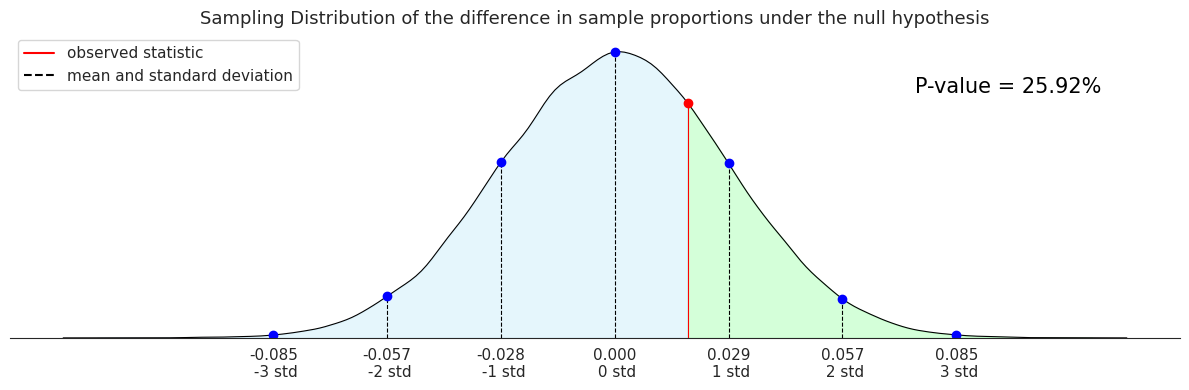

In [19]:
# Plotting the sampling distribution
statplot(null_vals, 15, obs_diff, 'Sampling Distribution of the difference in sample proportions under the null hypothesis')
shading(null_vals, obs_diff, null_vals.max(),'#aaffb5')
shading(null_vals, null_vals.min(), obs_diff,'#cceefb')
plt.text(0.075, 12, "P-value = {}".format(p_form), color = 'black', size = 15);

## Confidence Intervals

In [23]:
# Calculate z statistic
zscore = stats.norm.ppf(1 - .05)

# Calculate mean proportion for exposed group
p1 = exposed.yes.mean()
# Calculate mean proportion for control group
p2 = control.yes.mean()
# Calculate distance from the mean
distance_from_mean = ((p1*(1-p1)/exposed.yes.shape[0]) + (p2*(1-p2)/control.yes.shape[0])) ** 0.5 * zscore

# Lower boarder of the interval
low = obs_diff - distance_from_mean
# Higher boarder of the interval
high = obs_diff + distance_from_mean

print('The 90% confidence interval falls between {} and {}.'.format(low, high))

The 90% confidence interval falls between -0.02828080835958243 and 0.06485204695055077.


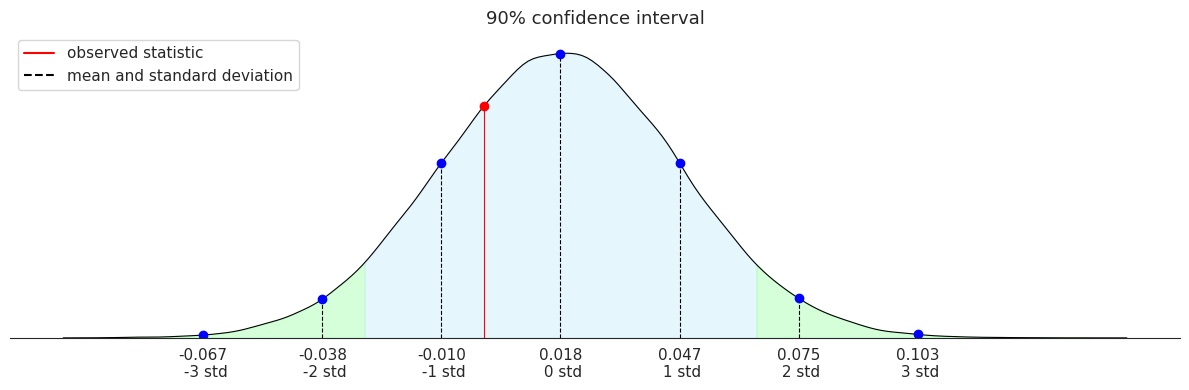

In [24]:
# Plotting the confidence interval
statplot(diffs, 15, np.mean(null_vals), '90% confidence interval')
shading(diffs, diffs.min(), low, '#aaffb5')
shading(diffs, low, high, '#cceefb')
shading(diffs, high, diffs.max(), '#aaffb5')

## Logistic Regression

In [30]:
# Create dummy variables for experiment variable
relevant_rows[['control', 'exposed']] = pd.get_dummies(relevant_rows.loc[:, 'experiment'])
relevant_rows = relevant_rows.drop(['control'], axis = 1)
# Add intercept
relevant_rows['intercept'] = 1

# Check data types of relevant columns and convert if necessary
print(relevant_rows['yes'].dtype)  # Check the data type of 'yes' column
print(relevant_rows[['intercept', 'exposed']].dtypes)  # Check data types of predictors

if relevant_rows['yes'].dtype == object:
    # Convert 'yes' column to numeric (assuming it contains binary values like 'yes' and 'no')
    relevant_rows['yes'] = relevant_rows['yes'].map({'yes': 1, 'no': 0})

# Explicitly convert relevant columns to numeric types
relevant_rows['yes'] = pd.to_numeric(relevant_rows['yes'])
relevant_rows['intercept'] = pd.to_numeric(relevant_rows['intercept'])
relevant_rows['exposed'] = pd.to_numeric(relevant_rows['exposed'])

# Force conversion to float in case they are integers
relevant_rows['yes'] = relevant_rows['yes'].astype(float)
relevant_rows['intercept'] = relevant_rows['intercept'].astype(float)
relevant_rows['exposed'] = relevant_rows['exposed'].astype(float)

#set up logistic regression model
logit_mod = sm.Logit(relevant_rows['yes'], relevant_rows[['intercept', 'exposed']])
#fitting logistic regression model
results = logit_mod.fit()
#display summary results
results.summary()

int64
intercept    int64
exposed       bool
dtype: object
Optimization terminated successfully.
         Current function value: 0.689804
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    yes   No. Observations:                 1243
Model:                          Logit   Df Residuals:                     1241
Method:                           MLE   Df Model:                            1
Date:                Wed, 12 Jun 2024   Pseudo R-squ.:               0.0002431
Time:                        20:44:33   Log-Likelihood:                -857.43
converged:                       True   LL-Null:                       -857.64
Covariance Type:            nonrobust   LLR p-value:                    0.5185
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1986      0.083     -2.392      0.017      -0.361      -0.036
exposed        0.0736      0.114      0.646      0.519      -0.150       0.297
==============================================================================
"""

- By - Ritvik Jain
- Stevens Institute of Technology